## Operationalization of Transfer Learning using Tensorflow in Azure ML

Azure ML studio is used to publish the trained model as Web serivces, which is connected with the IOS app using the URL and API key.

Requirements: 
* Zip tensorflow package, google package and the trained model into one zip file
* Upload it into AML as an input dataset (FoodClassifyModel.zip)


## AML experiment

### flowchart

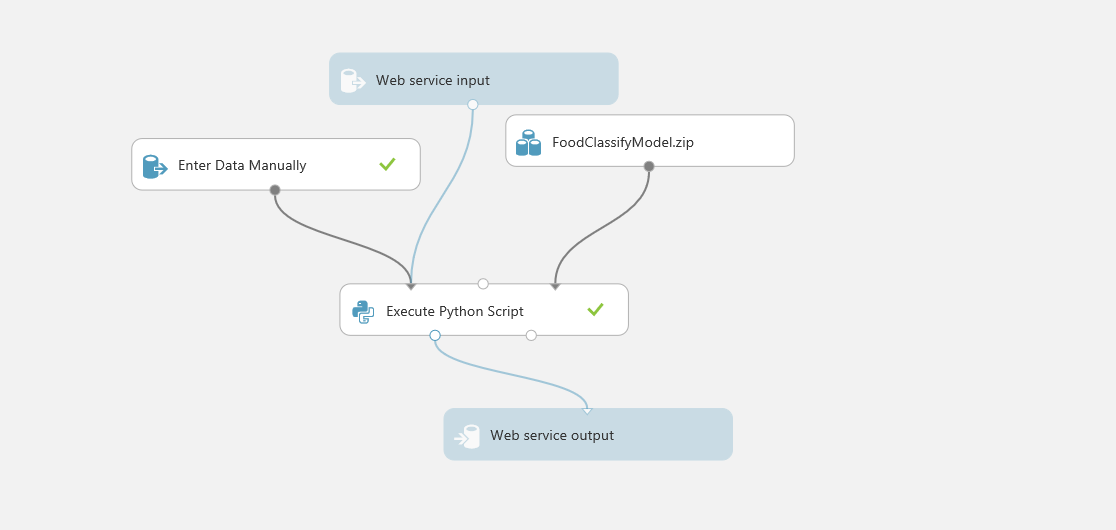

In [5]:
from IPython.display import Image
Image('AMLexperiement.png', width = 600, height = 500)

### Execute Python Script
* Put the following code inside the Execute Python Script Model
* Enter Data Mannually provides the URL of the test image.

In [ ]:
import os
import time
import random
import pandas as pd
import numpy as np
import sys
import tensorflow as tf
import urllib.request
from datetime import timedelta
import matplotlib.pyplot as plt
from IPython.display import display, Image
from scipy import ndimage
from PIL import Image
from six.moves import cPickle as pickle
from six.moves import range

def resize_image(image_file, width, height):
    try:
        pixel_depth = 255.0
        image = Image.open(image_file)
        # convert non-RGB image to RGB
        if image.mode == 'CMYK':
            print('Converting image %s from CMYK to RGB'%image_file)
            image = image.convert('RGB')
        im2 = image.resize((width, height),Image.ANTIALIAS)
        im2 = np.array(im2.getdata(), np.uint8).reshape(im2.size[1],im2.size[0],3)
    except:
      print("Resizing failed on file %s"%image_file)
    return im2

def load_resize_images(root_dir, folder, width, height):
    pixel_depth = 255.0
    folder = os.path.join(root_dir, folder)
    image_files = os.listdir(folder) # image file path
    dataset = np.ndarray(shape=(len(image_files), height, width, 3),
                         dtype=np.float16)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        filename, file_extension = os.path.splitext(image_file)
        if file_extension in [".jpg", ".JPG", ".jpeg"]:
            try:
                image_data = (np.array(Image.open(image_file)).astype(float) - 
                    pixel_depth / 2) / pixel_depth # get image data
                if len(image_data.shape) == 3:
                    if image_data.shape[2] < 3: # skip greyscale images
                        print("Image file %s has %d channels, skipping"%(image_file, image_data.shape[2]))
                    elif image_data.shape[0] < width or image_data.shape[1] < height: # skip too small size images
                        print("Image file %s is too small, skipping"%image_file)
                    else:
                        try:
                            image_data = resize_image(image_file, width, height)
                            dataset[num_images, :, :, :] = image_data
                            num_images = num_images + 1
                        except:
                            print("Could not resize %s, skipping"%image_file)
                else:
                    print("Image file %s only has %d dimensions, skipping"%(image_file, len(image_data.shape)))
            except IOError as e:
                print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
        else:
            print("Image file %s is not a jpg file, skipping"%image_file)
            
    dataset = dataset[0:num_images, :, :, :]
    print("%d images in folder %s are added into the pickle file"%(num_images, folder))
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset        
        
def maybe_pickle(root_dir, folder, width, height, force=False):
    dataset_names = []
    set_filename = folder + '.pickle'
    set_filename = os.path.join(root_dir, set_filename)
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
        print('%s already present - Skipping pickling.' % set_filename)
    else:
        print('Pickling %s.' % set_filename)

        dataset = load_resize_images(root_dir, folder, width, height)
        try:
            with open(set_filename, 'wb') as f:
                pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            print('Unable to save data to', set_filename, ':', e)
  
    return dataset_names
    
def reformat(dataset,width, height, num_channels, num_labels):
    dataset = dataset.reshape(
        (-1, height, width, num_channels)).astype(np.float32)
    return dataset

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))/predictions.shape[0])

def azureml_main(dataframe1 = None, dataframe2 = None):
    
    # download and preprocess the test image
    URL = str(dataframe1['imageURL'][0])
    if not os.path.exists('score'):
        os.mkdir('score')
    urllib.request.urlretrieve(URL, "./score/image.jpg") #the downloaded images are stored under "C:\\temp"
    
    image_dirs = ['score']
    width = 128
    height = 128
    num_labels = 5
    num_channels = 3 
    
    dataset_names = maybe_pickle("C:\\temp", image_dirs[0], width, height)
    print (dataset_names)

    data_root = 'C:\\temp\\Script Bundle' 
    pickle_file ="C:\\temp\\score.pickle"
    
    with open(pickle_file, 'rb') as f:
        save = pickle.load(f)
        test_dataset = save
        del save  # hint to help gc free up memory
        print('Testing set', test_dataset.shape)
    
    test_dataset = reformat(test_dataset, height, width, num_channels, num_labels)
    print('Test set', test_dataset.shape)
    
    # pass the image through inception model
    import inception
    inception.maybe_download() # download incpetion model
    model = inception.Inception() # load the Inception model

    from inception import transfer_values_cache
    
    file_path_cache_test = os.path.join(data_root, 'inception_test.pkl')
    
    print("Processing Inception transfer-values for test-images ...")
    transfer_values_test = transfer_values_cache(cache_path=file_path_cache_test,
                                                images=test_dataset,
                                                model=model)
    print (transfer_values_test.shape)
    
    # pass the transfer values from inception model to the saved tensorflow model
    print ("Load Tensorflow Model ...")
    sess=tf.Session()
    saver = tf.train.import_meta_graph(os.path.join(data_root,'model\\model.meta'))
    saver.restore(sess,tf.train.latest_checkpoint(os.path.join(data_root,'model\\')))
    
    graph = tf.get_default_graph()
    x = graph.get_tensor_by_name("x:0") 
    op_to_restore = graph.get_tensor_by_name("restore_model:0")
    feed_dict = {x : transfer_values_test}
    output = np.argmax(sess.run(op_to_restore, feed_dict),1)
    print (np.argmax(sess.run(op_to_restore, feed_dict),1))
    
    # generate output label
    output_labels = pd.DataFrame(output)
    output_labels.columns = ['label']
    dish_dict = {0:'Chaomian', 1: 'Kung Po Chicken', 2: 'Roujiamo', 3:'Burger', 4:'Sweet And Sour Pork'}
    label = []
    for i in output_labels['label']:
        label.append(dish_dict[int(i)])
    label = pd.DataFrame(label)
    
    # clean the local folder
    os.remove(pickle_file) # remove the pickle file 
    os.remove(file_path_cache_test) # remove the inception intermediate file
    
    return label,
